# CNN
CNNs are often for spatial data like images, but using them here to capture patterns across different periods.

In [1]:
from data_loader import load_names_from_web, holdout_split

In [2]:
# pip install keras-tuner

In [3]:
# multivariate multi-step data preparation
import numpy as np
from numpy import array
from numpy import hstack

import pandas as pd

from keras.models import Sequential
# from keras.layers import LSTM, RepeatVector, TimeDistributed, MaxPooling1D
from keras.layers import Dense, Flatten, Conv1D, Input

from keras.optimizers import Adam
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch
# from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler





## load and format data

In [4]:
dfraw = load_names_from_web(category="national", hide_pre_1937=True, use_existing_files=True)
dfraw.sample(5)

,state,year,name,M/F,count
662214,US,1973,Wendie,F,52
839867,US,1959,Nilsa,F,70
800046,US,1970,Lanelle,F,18
102809,US,2015,Nalayah,F,27
1420377,US,1996,Rashel,F,16


In [89]:
df1 = dfraw.copy()
df1['name_g'] = df1['name'] + '_' + df1['M/F']
df1.drop(columns=['state', 'name', 'M/F'], inplace=True)
df1.head()

,year,count,name_g
0,2000,25957,Emily_F
1,2000,23085,Hannah_F
2,2000,19968,Madison_F
3,2000,17998,Ashley_F
4,2000,17712,Sarah_F


In [90]:
# for now, lets just look at names that have been used continuously throughout the years.
# for later iterations, can replace this cell with another cell creating df2
unique_years = df1['year'].nunique()
complete_records = df1.groupby('name_g').filter(lambda x: x['year'].nunique() == unique_years)
df2 = complete_records.reset_index(drop=True)
print(df2.shape, 'names: ', df2['name_g'].nunique())
df2.head()

(202702, 3) names:  2357


,year,count,name_g
0,2000,25957,Emily_F
1,2000,23085,Hannah_F
2,2000,17712,Sarah_F
3,2000,17265,Samantha_F
4,2000,15711,Jessica_F


In [91]:
# reformat the dataframe with a column for each name
df3 = df2.pivot(index='year', columns='name_g', values='count')
print(df3.shape)
df3.head()

(86, 2357)


name_g,Aaron_M,Abbie_F,Abby_F,Abe_M,Abel_M,Abelardo_M,Abigail_F,Abner_M,Abraham_M,Abram_M,...,Zack_M,Zana_F,Zane_M,Zeb_M,Zelda_F,Zena_F,Zenobia_F,Zina_F,Zoe_F,Zulema_F
year,,,,,,,,,,,,,,,,,,,,,
1937,465,52,25,63,91,25,45,39,217,31,...,32,15,49,17,147,16,33,12,72,8
1938,477,56,21,55,87,28,50,49,212,37,...,31,15,62,15,145,16,36,11,65,17
1939,471,70,24,56,95,31,53,34,197,31,...,33,8,61,12,127,13,47,15,55,19
1940,514,57,37,54,101,33,48,34,219,23,...,18,18,68,16,128,19,35,13,54,18
1941,562,50,32,66,121,17,40,38,194,29,...,30,10,52,11,106,21,25,14,60,21


## normalize
so the NN can converge more quickly

In [92]:
# this creates a scaler for each name
scalers = {name: StandardScaler() for name in df3.columns}

In [93]:
df4 = df3.copy()
for name in df4.columns:
    df4[name] = scalers[name].fit_transform(df4[name].values.reshape(-1, 1))

## separate the train / validation / test data and sequences 
The aproach here is that the names are independent -- they do not affect each other. However, they might have similar shapes/patterns at different times. So to make predictions, the model should learn from all of the time series. Sequences from multiple names are combined into a single training set.

I will do it this way:
1. separate the names that will be used for the test set.
2. If I am using m names to predict n years into the future, the **validation y will consist of the last n years for each name.** The validation X data will consist of the m previous years for each name.
3. **The train X and y data will not overlap with any of the last n years.** 
4. (I believe I can use test names for training as long as the training X and y do not touch any of the last n years, but I will **not** do that for now)

An assumption is being made here that typical shapes have not changed in recent years.

In [94]:
input_length = 10
pred_length = 2
test_size = 0.2

xy_seq_length = input_length + pred_length

In [95]:
# separate the names that will be used for final test. I also only want the last years for test
test_df = df4.sample(frac = test_size, random_state=42, axis=1).tail(xy_seq_length)
train_val = df4.drop(test_df.columns, axis=1)
print(df4.shape, train_val.shape, test_df.shape)

(86, 2357) (86, 1886) (12, 471)


In [13]:
# split train and validation
val_df = train_val.tail(xy_seq_length)
train_df1 = train_val.head(len(train_val)-xy_seq_length)
print(train_df1.shape, val_df.shape)

(74, 1886) (12, 1886)


In [1]:
# val and test are already formatted as subsequences, each column is a time series subsequence m + n long
# now we will format train in the same way
def array_to_sequences(train_array, input_length, pred_length):
    '''
    input: an array (where each column is a time series)
    creates a new array where each column is a time-series sub sequence    
    '''
    subsequence_length = input_length + pred_length
    n_subsequences = train_array.shape[0] - subsequence_length + 1
    
    subsequences = []
    for col in range(train_array.shape[1]):
        for start_row in range(n_subsequences):
            subsequence = train_array[start_row:start_row+subsequence_length, col]
            subsequences.append(subsequence)

    sequence_array = np.array(subsequences).T

    return sequence_array

In [15]:
train_array = array_to_sequences(train_df1.to_numpy(), input_length, pred_length)
train_array.shape

(12, 118818)

In [17]:
test_array = test_df.to_numpy()
val_array = val_df.to_numpy()
print(train_array.shape, val_array.shape, test_array.shape)

(12, 118818) (12, 1886) (12, 471)


CNNs in Keras expect input data to be in the form of a 3D array of shape (batch_size, timesteps, features), where:
* batch_size is the number of sequences.
* timesteps is the sequence length (in years for this).
* features is the number of features per timestep (1 since treating this as univariate time series).

In [46]:
def split_xy_for_keras(arr1, steps_in, steps_out):
    # chop off bottom of array for y. Transpose it
    y1 = arr1[-steps_out:,:].T
    # add dimension for keras
    y2 = np.expand_dims(y1, 2)
    
    # chop off top of array for x. Transpose it
    x1 = arr1[0:steps_in,:].T
    # add dimension for keras
    x2 = np.expand_dims(x1, 2)
    
    return x2, y2    

In [49]:
x_train, y_train = split_xy_for_keras(train_array, input_length, pred_length)
x_val, y_val = split_xy_for_keras(val_array, input_length, pred_length)
x_test, y_test = split_xy_for_keras(test_array, input_length, pred_length)
x_train.shape

(118818, 10, 1)

In [50]:
y_train.shape

(118818, 2, 1)

In [53]:
x_test.shape

(471, 10, 1)

## build model

In [57]:
input_shape = (input_length, 1)

In [60]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Choice('kernel_size_1', values=[2, 3]),
                     activation='relu')) # , input_shape=input_shape
    # model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    # model.add(Conv1D(filters=hp.Int('filters_2', min_value=64, max_value=256, step=32),
    #                  kernel_size=hp.Choice('kernel_size_2', values=[2, 3]),
    #                  activation='relu'))
    # model.add(BatchNormalization())
    # model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(units=hp.Int('units', min_value=50, max_value=200, step=50), activation='relu'))
    model.add(Dense(2 * 1))  # 2 * number_of_features_per_year

    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='mse',       # adjust?
                  metrics=['mae'])  # adjust?

    return model

In [61]:
tuner = RandomSearch(
    build_model,
    objective='val_mae',  # Adjust based on what you care more about
    max_trials=10,  # Set the number of adjustments
    executions_per_trial=1,  # How many models to build for each trial
    directory='my_dir',  # Directory to save logs and models
    project_name='time_series_prediction'
)

In [62]:
# takes time: laptop: 10 trials x 20 epochs was 6+ minutes







# Perform hyperparameter search
tuner.search(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

Trial 10 Complete [00h 00m 25s]
val_mae: 0.2802698314189911

Best val_mae So Far: 0.2675422430038452
Total elapsed time: 00h 06m 18s


In [63]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [64]:
# Build the model with the best hp
model = tuner.hypermodel.build(best_hps)

In [65]:
# takes time: 100 epochs -> 200 seconds?



# Train the best model
model.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val))

Epoch 1/100
3714/3714 ━━━━━━━━━━━━━━━━━━━━ 2s 569us/step - loss: 0.1579 - mae: 0.2488 - val_loss: 0.2449 - val_mae: 0.2770
Epoch 2/100
3714/3714 ━━━━━━━━━━━━━━━━━━━━ 2s 540us/step - loss: 0.1384 - mae: 0.2276 - val_loss: 0.2655 - val_mae: 0.2909
Epoch 3/100
3714/3714 ━━━━━━━━━━━━━━━━━━━━ 2s 536us/step - loss: 0.1372 - mae: 0.2242 - val_loss: 0.3662 - val_mae: 0.3227
Epoch 4/100
3714/3714 ━━━━━━━━━━━━━━━━━━━━ 2s 536us/step - loss: 0.1337 - mae: 0.2217 - val_loss: 0.2791 - val_mae: 0.2913
Epoch 5/100
3714/3714 ━━━━━━━━━━━━━━━━━━━━ 2s 535us/step - loss: 0.1342 - mae: 0.2221 - val_loss: 0.3323 - val_mae: 0.3195
Epoch 6/100
3714/3714 ━━━━━━━━━━━━━━━━━━━━ 2s 550us/step - loss: 0.1358 - mae: 0.2232 - val_loss: 0.3535 - val_mae: 0.3482
Epoch 7/100
3714/3714 ━━━━━━━━━━━━━━━━━━━━ 2s 540us/step - loss: 0.1346 - mae: 0.2217 - val_loss: 0.2894 - val_mae: 0.3239
Epoch 8/100
3714/3714 ━━━━━━━━━━━━━━━━━━━━ 2s 534us/step - loss: 0.1328 - mae: 0.2209 - val_loss: 0.3244 - val_mae: 0.3202
Epoch 9/100
3714

Epoch 53/100
3714/3714 ━━━━━━━━━━━━━━━━━━━━ 2s 552us/step - loss: 0.1325 - mae: 0.2189 - val_loss: 0.3530 - val_mae: 0.3284
Epoch 54/100
3714/3714 ━━━━━━━━━━━━━━━━━━━━ 2s 529us/step - loss: 0.1305 - mae: 0.2181 - val_loss: 0.2745 - val_mae: 0.2880
Epoch 55/100
3714/3714 ━━━━━━━━━━━━━━━━━━━━ 2s 552us/step - loss: 0.1320 - mae: 0.2188 - val_loss: 0.3131 - val_mae: 0.3065
Epoch 56/100
3714/3714 ━━━━━━━━━━━━━━━━━━━━ 2s 535us/step - loss: 0.1337 - mae: 0.2199 - val_loss: 0.2984 - val_mae: 0.2950
Epoch 57/100
3714/3714 ━━━━━━━━━━━━━━━━━━━━ 2s 528us/step - loss: 0.1296 - mae: 0.2173 - val_loss: 0.2706 - val_mae: 0.2975
Epoch 58/100
3714/3714 ━━━━━━━━━━━━━━━━━━━━ 2s 548us/step - loss: 0.1321 - mae: 0.2187 - val_loss: 0.3211 - val_mae: 0.3084
Epoch 59/100
3714/3714 ━━━━━━━━━━━━━━━━━━━━ 2s 530us/step - loss: 0.1297 - mae: 0.2164 - val_loss: 0.3312 - val_mae: 0.3221
Epoch 60/100
3714/3714 ━━━━━━━━━━━━━━━━━━━━ 2s 553us/step - loss: 0.1354 - mae: 0.2206 - val_loss: 0.3978 - val_mae: 0.3967
Epoch 61

## score and plot

In [66]:
test_loss, test_metric = model.evaluate(x_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Metric (e.g., MAE): {test_metric}')


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 0.2640 - mae: 0.2993
Test Loss: 0.28025704622268677
Test Metric (e.g., MAE): 0.3101375997066498


In [68]:
y_pred = model.predict(x_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [72]:
print(y_pred.shape, y_test.shape)

(471, 2) (471, 2, 1)


In [74]:
y_test = y_test.reshape(-1, 2)  # Adjusting shape: removing dimension
y_test.shape

(471, 2)

Plot the first 10 or so, as is:

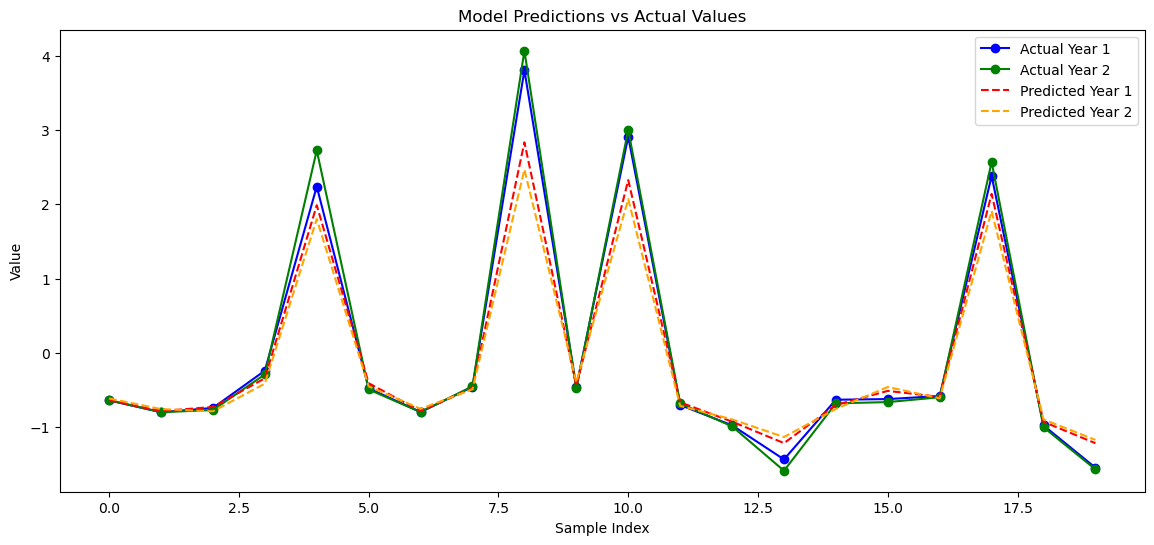

In [77]:

# Plotting
plt.figure(figsize=(14, 6))

# Plot the actual values
plt.plot(y_test[0:20:, 0], label='Actual Year 1', color='blue', marker='o')
plt.plot(y_test[0:20:, 1], label='Actual Year 2', color='green', marker='o')

# Plot the predicted values
plt.plot(y_pred[0:20:, 0], label='Predicted Year 1', color='red', linestyle='--')
plt.plot(y_pred[0:20:, 1], label='Predicted Year 2', color='orange', linestyle='--')

plt.title('Model Predictions vs Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

Now un-scale the predictions and plot against actuals

In [96]:
pred_df = pd.DataFrame(y_pred)
pred_df = pred_df.T
pred_df.index = list(test_df.tail(pred_length).index)
pred_df.columns = test_df.columns
for name in pred_df.columns:
    pred_df[name] = scalers[name].inverse_transform(pred_df[name].values.reshape(-1, 1))
pred_df

name_g,Mildred_F,Janice_F,Matthew_M,Spencer_M,Asa_M,Paris_M,Jim_M,Cody_M,Milo_M,Mable_F,...,Luana_F,Vidal_M,Silvia_F,Genoveva_F,Samantha_F,Silverio_M,Garth_M,Bennie_M,Millie_F,Drew_M
2021,104.225189,165.599457,7653.335449,919.804504,544.346069,67.365829,57.587608,983.866333,2257.541016,51.499191,...,99.781250,33.156994,157.540039,11.344002,2455.833496,12.672924,26.975471,63.164742,1348.884888,477.394012
2022,135.296539,306.185638,6761.790527,831.021912,510.705017,64.641029,104.979210,913.213745,2011.237061,60.546806,...,100.973991,32.721931,161.638351,12.120861,1883.702759,13.279573,31.195942,74.766792,1314.506592,411.369812


In [100]:
actual_df = df3[list(pred_df.columns)]
actual_df.head()

name_g,Mildred_F,Janice_F,Matthew_M,Spencer_M,Asa_M,Paris_M,Jim_M,Cody_M,Milo_M,Mable_F,...,Luana_F,Vidal_M,Silvia_F,Genoveva_F,Samantha_F,Silverio_M,Garth_M,Bennie_M,Millie_F,Drew_M
year,,,,,,,,,,,,,,,,,,,,,
1937,4645,7768,606,180,65,19,2348,22,111,691,...,30,16,33,27,23,15,83,885,205,20
1938,4440,8710,607,206,60,31,2496,21,95,641,...,31,20,46,18,17,17,82,872,216,36
1939,4137,8780,622,260,50,26,2636,20,85,639,...,46,19,44,21,23,10,60,876,242,44
1940,3937,9318,664,260,53,18,2715,19,100,589,...,35,13,48,40,19,21,86,845,232,49
1941,3848,10062,727,291,60,17,2843,23,94,539,...,41,21,44,23,20,17,73,839,224,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018,93,154,9995,1112,564,78,39,1252,2197,38,...,90,37,160,6,3918,9,15,38,1096,630
2019,77,141,9254,1037,565,74,39,1209,2439,37,...,95,37,182,7,3367,15,16,43,1316,552
2020,96,97,8120,1045,573,68,40,1129,2766,45,...,95,26,157,12,2952,12,20,53,1503,536


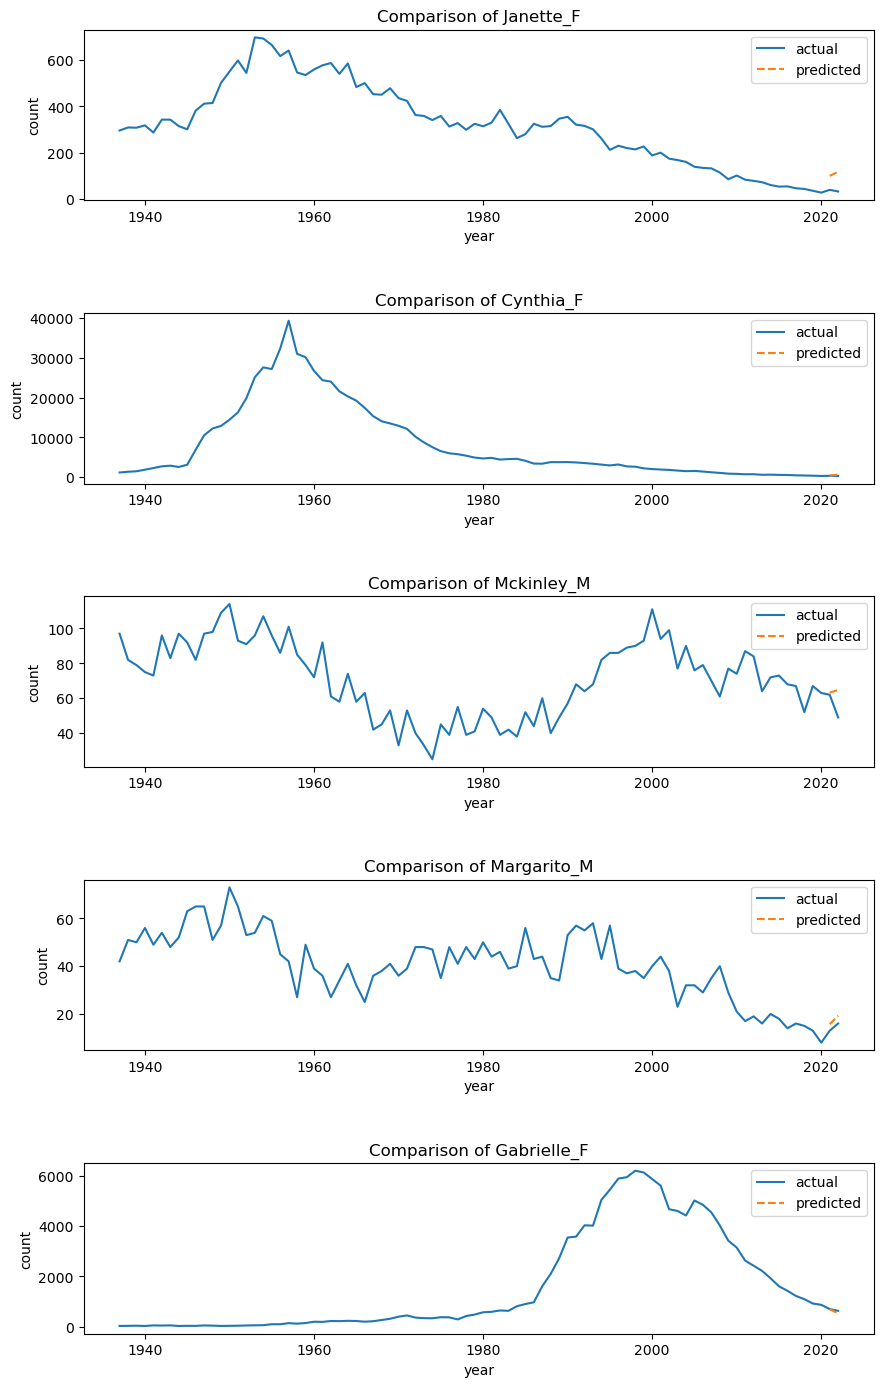

In [101]:
# plot some
num_to_plot = 5
np.random.seed(42)
columns_to_plot = np.random.choice(actual_df.columns, size=5, replace=False)
fig, axes = plt.subplots(nrows=num_to_plot, ncols=1, figsize=(10, 15))
fig.tight_layout(pad=6.0)
for i, col in enumerate(columns_to_plot):
    axes[i].plot(actual_df.index, actual_df[col], label='actual', linestyle='-') # , marker='o'
    axes[i].plot(pred_df.index, pred_df[col], label='predicted', linestyle='--') # , marker='x'
    
    axes[i].set_title(f'Comparison of {col}')
    axes[i].set_xlabel('year')
    axes[i].set_ylabel('count')
    axes[i].legend()

plt.show()


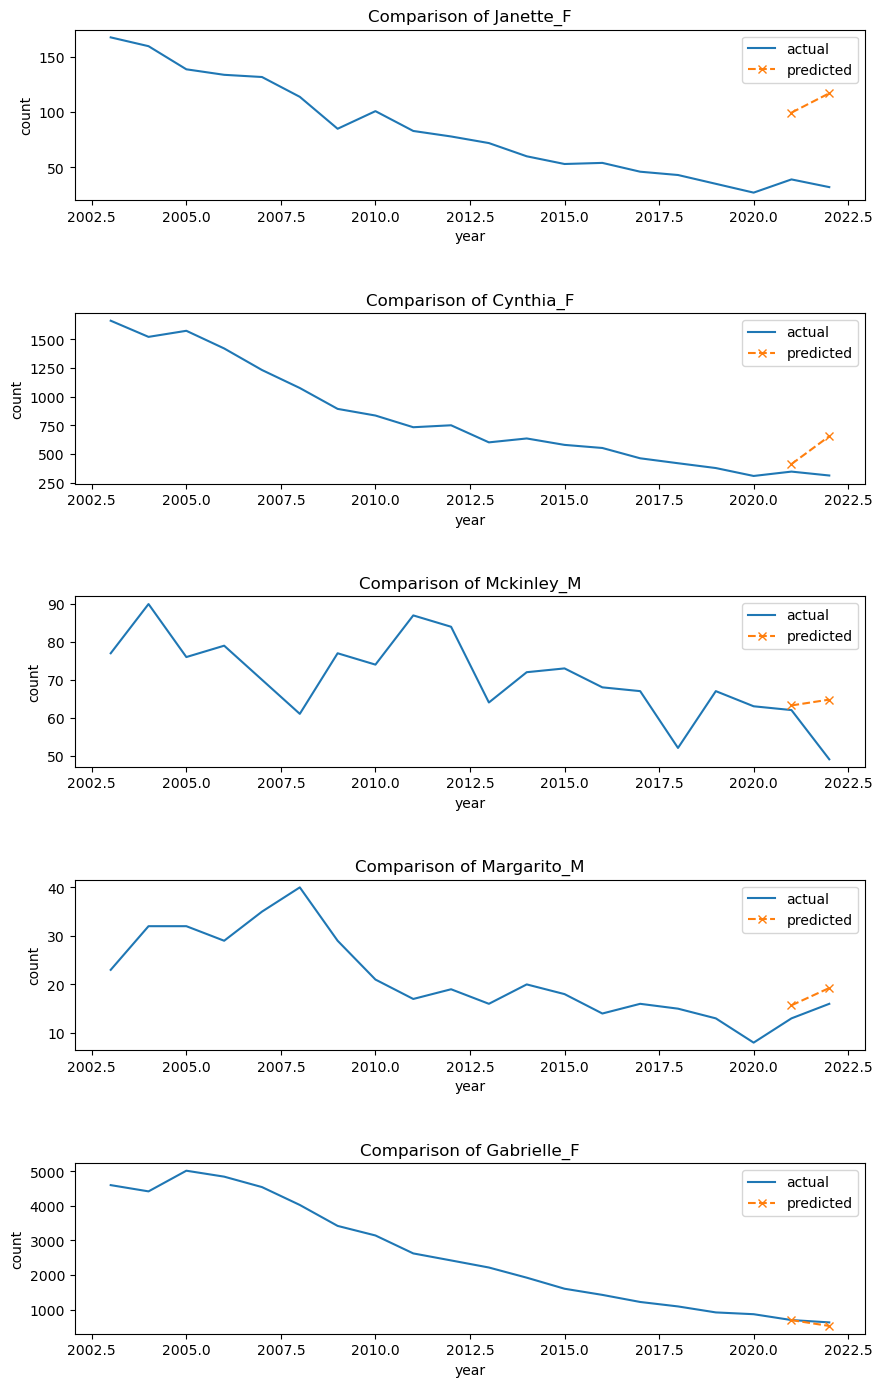

In [103]:
num_years_to_show = 20
fig, axes = plt.subplots(nrows=num_to_plot, ncols=1, figsize=(10, 15))
fig.tight_layout(pad=6.0)
for i, col in enumerate(columns_to_plot):
    axes[i].plot(actual_df.index[-num_years_to_show:], actual_df[col].tail(num_years_to_show), label='actual', linestyle='-')
    axes[i].plot(pred_df.index, pred_df[col], label='predicted', marker='x', linestyle='--')
    
    axes[i].set_title(f'Comparison of {col}')
    axes[i].set_xlabel('year')
    axes[i].set_ylabel('count')
    axes[i].legend()

plt.show()